In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [125]:
def plot_data(data):
    x_label = data.columns[0]
    y_label = data.columns[1]
    plt.plot(data[x_label], data[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [126]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean()

In [127]:
def format_pd(data, feature):
    data = data.dropna()
    # Arranca en t = 0
    #print(data["t"].iloc[0])
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    try:
        data = data[["t", feature]]
    except KeyError:
        data = data[["t", "θ"]]
    data = data[data["t"] <=5]
    return data

In [128]:
def get_tita0(data):
    try:
        return data["θr"].iloc[0]
    except KeyError:
        return data["θ"].iloc[0]

def get_amplitud(data):  # asumo amplitud como Asen(θ)
    try:
        return (max(data["θr"]) - min(data["θr"])) / 2
    except KeyError:
        return (max(data["θ"]) - min(data["θ"])) / 2

def get_periodo(data):
    try:
        # Localizo un máximo y un mínimo
        maximo = data["θ"].idxmax()
        minimo = data["θ"].idxmin()
        # Calculo el periodo
        return abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2 # *2 porque es de pico a pico
    except KeyError:
        # Localizo un máximo y un mínimo
        maximo = data["θr"].idxmax()
        minimo = data["θr"].idxmin()
        # Calculo el periodo
        return abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2 # *2 porque es de pico a pico

def get_frecuencia(data):
    return 1 / get_periodo(data) # NO está en rad/sec, está en Hz

In [129]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
    x = data["t"]
    #print(x[0])
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    #print(y[0])
    plt.plot(x, y)

In [130]:
import os
import pandas as pd

# Adjust the input directory path to go up one level from the current directory
input_dir = os.path.join('..', 'datasets')

datasets = []

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                # Add dataset to the list with subfolder and folder
                datasets.append(os.path.join(folder, file))

dataset_params = []

for i, dataset in enumerate(datasets):
    print(f"{i}: {dataset}")
    # Load a specific dataset into a DataFrame
    DATASET_CHOSEN = i
    data = pd.read_csv(os.path.join(input_dir, datasets[DATASET_CHOSEN]))
    L = get_largo(data)
    data = format_pd(data, "θr")
    plot_data(data)
    tita0, amplitud, T, frecuencia = get_tita0(data), get_amplitud(data), get_periodo(data), get_frecuencia(data)
    dataset_params.append((L, tita0, amplitud, T, frecuencia, (23 if dataset.split()[0] == "plata" else 72)))
    print(f"θ0: {tita0}, A: {amplitud}, T: {T}, f: {frecuencia}")
    plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T)
    plt.show()


C:\Users\xxx\AppData\Local\Temp\ipykernel_19432\2926403542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


In [131]:
def graph_params(dataset_params):
    # Creo un DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m"])

    # Fit a linear regression model to estimate gravity
    # Convierte a un array de 2D: reshape(-1, 1)
    reg = LinearRegression().fit(df["L"].values.reshape(-1, 1), (df["T"]**2).values.reshape(-1, 1))

    # Plot T^2 vs L
    plt.figure()
    plt.scatter(df["L"], df["T"]**2, label='Data')
    x = np.linspace(df["L"].min(), df["L"].max(), 100)
    plt.plot(x, reg.predict(x.reshape(-1, 1)), color="orange", label='Linear Fit')
    g = 9.80665 * 100
    plt.plot(x, (4 * np.pi**2 / g) * x, color="red", label='Theoretical')
    plt.xlabel('Length (L)')
    plt.ylabel('Period Squared (T^2)')
    plt.title('T^2 vs L')
    plt.legend()
    plt.show()

    # Estimate gravity (g) from the slope (T^2 = (4 * pi^2 / g) * L)
    slope = reg.coef_[0][0]
    g_estimated = (4 * np.pi**2 / slope) / 100 # cm to m
    print(f"Estimated gravity (g): {g_estimated} m/s^2")

    # T vs m with color gradient based on L value
    df["L"] = df["L"].round(1)
    filtered_df = df
    unique_lengths = np.sort(filtered_df["L"].unique())  # Sort the unique lengths
    norm = plt.Normalize(filtered_df["L"].min(), filtered_df["L"].max())
    colors = plt.cm.viridis(norm(unique_lengths))
    
    plt.figure()
    ax = plt.gca()  # Get current axes
    for length, color in zip(unique_lengths, colors):
        subset = filtered_df[filtered_df["L"] == length]
        ax.scatter(subset["m"], subset["T"], color=color)#, label=f'L={length:.2f}')
    
    plt.xlabel("Masa (m)")
    plt.ylabel("T (s)")
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Length (L)')
    plt.legend()
    plt.show()
    
    # T vs tita0 with color gradient based on L value
    plt.figure()
    ax = plt.gca()  # Get current axes
    for length, color in zip(unique_lengths, colors):
        subset = filtered_df[filtered_df["L"] == length]
        ax.scatter(subset["tita0"], subset["T"], color=color)#, label=f'L={length:.2f}')
    
    plt.xlabel("θ0 (rad)")
    plt.ylabel("T (s)")
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Length (L)')
    plt.legend()
    plt.show()

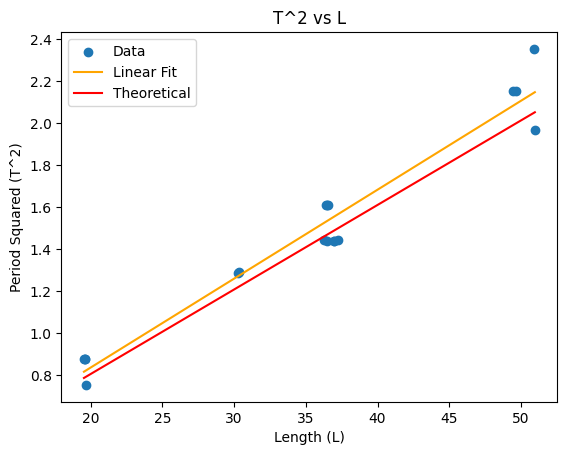

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Estimated gravity (g): 9.321590301406264 m/s^2


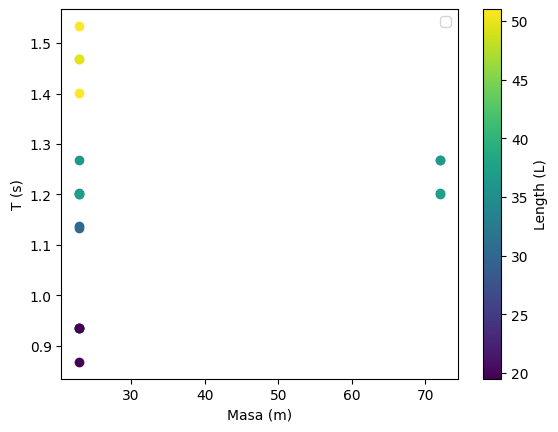

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


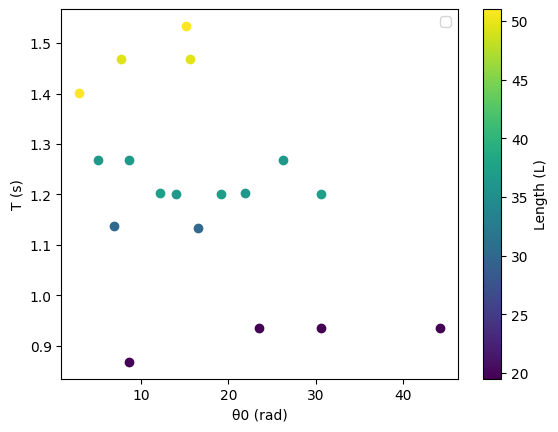

In [132]:
graph_params(dataset_params)